## Pytorch 手写字识别

通过对`MNIST`手写字识别来熟悉`Pytorch`用法，参考：

- [Pytorch神经网络工具箱](http://www.feiguyunai.com/index.php/2019/09/11/pytorch-char03/)
- [nndl_note: 识别手写字](https://www.howie6879.cn/p/nndl_note-%E8%AF%86%E5%88%AB%E6%89%8B%E5%86%99%E5%AD%97/)

流程图：

![FCRQrO](https://gitee.com/howie6879/oss/raw/master/uPic/FCRQrO.jpg)

> 👉 图来源自上述：Pytorch神经网络工具箱

In [1]:
%load_ext watermark
%watermark -v -p numpy,torch

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.27.0

numpy: 1.21.2
torch: 1.8.2



In [2]:
# 可视化模块
import matplotlib.pyplot as plt
import numpy as np
import torch

# 导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim

# 导入预处理模块
import torchvision.transforms as transforms
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader

# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist

%matplotlib inline

### 获取数据

In [3]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 10
lr = 0.01
momentum = 0.5

In [4]:
# 定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)
# 下载数据，并对数据进行预处理
train_dataset = mnist.MNIST("./data", train=True, transform=transform, download=True)
test_dataset = mnist.MNIST("./data", train=False, transform=transform)
# dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/home/howie/anaconda3/envs/gpu_env38/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1627336325426/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### utils.data 简介

允许开发者自定义数据集

In [5]:
# 继承Dataset
class TestDataset(data.Dataset):
    def __init__(self):
        self.Data = np.asarray(
            [[1, 2], [3, 4], [2, 1], [3, 4], [4, 5]]
        )  # 一些由2维向量表示的数据集
        self.Label = np.asarray([0, 1, 0, 1, 2])  # 这是数据集对应的标签

    def __getitem__(self, index):
        # 把numpy转换为Tensor
        txt = torch.from_numpy(self.Data[index])
        label = torch.tensor(self.Label[index])
        return txt, label

    def __len__(self):
        return len(self.Data)

In [6]:
Test = TestDataset()
Test

In [7]:
Test[0]

(tensor([1, 2]), tensor(0))

In [8]:
# 以上数据以tuple返回，每次只返回一个样本
# 如果要对 Dataset 做一些批量提取、随机化等操作
# 此时可以引入 DataLoader

test_loader_demo = data.DataLoader(Test, batch_size=3, shuffle=False, num_workers=2)
for i, traindata in enumerate(test_loader_demo):
    print("i:", i)
    Data, Label = traindata
    print("data:", Data)
    print("Label:", Label)

i: 0
data: tensor([[1, 2],
        [3, 4],
        [2, 1]])
Label: tensor([0, 1, 0])
i: 1
data: tensor([[3, 4],
        [4, 5]])
Label: tensor([1, 2])


### 数据可视化

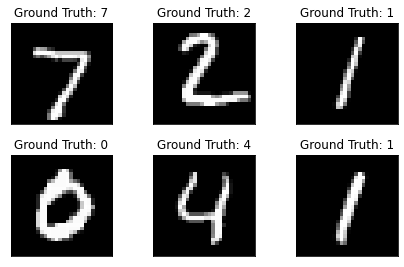

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [10]:
example_data[0][0].shape

torch.Size([28, 28])

### 构建模型

通过全连接神经网络和卷积神经网络构建模型来熟悉Pytorch的模型构建方式

相关知识点参考：
- [PyTorch的nn.Linear详解](https://blog.csdn.net/qq_42079689/article/details/102873766)

#### 全连接神经网络

In [11]:
class Net01(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """

    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net01, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2)
        )
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [12]:
# 检测是否有可用的GPU，有则使用，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 实例化网络
model = Net01(28 * 28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [13]:
28 * 28

784

In [14]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []


# num_epoches
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch % 5 == 0:
        optimizer.param_groups[0]["lr"] *= 0.1
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        # 64 * 784
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        #         print(out.shape, loss)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        #         print(out.shape, loss, pred)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc

    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print(
        "epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(
            epoch,
            train_loss / len(train_loader),
            train_acc / len(train_loader),
            eval_loss / len(test_loader),
            eval_acc / len(test_loader),
        )
    )

epoch: 0, Train Loss: 1.0454, Train Acc: 0.7802, Test Loss: 0.5583, Test Acc: 0.9033
epoch: 1, Train Loss: 0.4837, Train Acc: 0.9019, Test Loss: 0.3470, Test Acc: 0.9283
epoch: 2, Train Loss: 0.3476, Train Acc: 0.9213, Test Loss: 0.2681, Test Acc: 0.9390
epoch: 3, Train Loss: 0.2824, Train Acc: 0.9332, Test Loss: 0.2265, Test Acc: 0.9468
epoch: 4, Train Loss: 0.2413, Train Acc: 0.9413, Test Loss: 0.1950, Test Acc: 0.9524
epoch: 5, Train Loss: 0.2215, Train Acc: 0.9467, Test Loss: 0.1937, Test Acc: 0.9520
epoch: 6, Train Loss: 0.2172, Train Acc: 0.9464, Test Loss: 0.1900, Test Acc: 0.9539
epoch: 7, Train Loss: 0.2162, Train Acc: 0.9468, Test Loss: 0.1881, Test Acc: 0.9534
epoch: 8, Train Loss: 0.2132, Train Acc: 0.9486, Test Loss: 0.1860, Test Acc: 0.9544
epoch: 9, Train Loss: 0.2096, Train Acc: 0.9484, Test Loss: 0.1832, Test Acc: 0.9551
epoch: 10, Train Loss: 0.2086, Train Acc: 0.9492, Test Loss: 0.1812, Test Acc: 0.9542
epoch: 11, Train Loss: 0.2088, Train Acc: 0.9490, Test Loss: 0.1

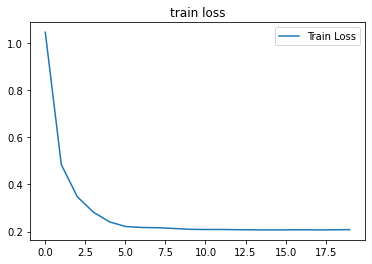

In [15]:
plt.title("train loss")
plt.plot(np.arange(len(losses)), losses)
plt.legend(["Train Loss"], loc="upper right")